In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
import numpy as np
import math
import shap
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns

DATA PREPARATION

In [2]:
df = pd.read_csv('NFL PBP.csv')

Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
df.shape

(449371, 255)

In [4]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
df.loc[df['yards_gained'] < 3, 'yards_gained'] = 0
df.loc[(df['yards_gained'] >= 3) & (df['yards_gained'] < 6), 'yards_gained'] = 1
df.loc[(df['yards_gained'] >= 6) & (df['yards_gained'] < 10), 'yards_gained'] = 2
df.loc[df['yards_gained'] >= 10, 'yards_gained'] = 3

In [6]:
df['game_id'] = df['game_id'].astype(str)
df['desc'] = df['desc'].astype(str)

# clean the data
for i in range(len(df['game_id'])):
    df.at[i, 'Year'] = df['game_id'][i][0:4] # will give the year of the game
    
for i in range(len(df['desc'])):
    if df['desc'][i].count('(') >= 1:
        # access the first letter before period and the word after (this will give full name; all in the description 'desc')
        number = df['desc'][i].find('.') 
        df.at[i, 'Player'] = df['desc'][i][number-1] + ' ' + df['desc'][i][number+1:].split(' ')[0]
    else:
        pass # do nothing

nfl_data = df[['game_seconds_remaining', 
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained',
               'yardline_100',
               'Player',
               'Year']].query(
                '(play_type == "pass") or (play_type == "run")').dropna()
nfl_data.head()

,game_seconds_remaining,ydstogo,posteam_score,defteam_score,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained,yardline_100,Player,Year
1,3593.0,10,0.0,0.0,1.0,0,pass,0,0,1.0,58.0,B Roethlisberger,2009
2,3556.0,5,0.0,0.0,2.0,0,run,0,0,0.0,53.0,W Parker,2009
3,3515.0,8,0.0,0.0,3.0,1,pass,0,0,0.0,56.0,B Roethlisberger,2009
5,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009
6,3460.0,10,0.0,0.0,2.0,0,pass,0,0,1.0,98.0,K Collins,2009


In [7]:
nfl_data.shape

(318347, 13)

In [8]:
# create dictionary with all of the passing dataframes
years = list(range(2009,2019,1))

d = {}
for year in years:
    df = pd.read_csv(f'Pass {year}.csv')
    d[year] = df[['Player', 'Age', 'QBR', 'Y/G', 'Rate']]

In [9]:
d[2009].head()

,Player,Age,QBR,Y/G,Rate
0,Matt Schaub*\SchaMa00,28,73.8,298.1,98.6
1,Peyton Manning*+\MannPe00,33,81.3,281.3,99.9
2,Tom Brady*\BradTo00,32,73.2,274.9,96.2
3,Jay Cutler\CutlJa00,26,50.3,229.1,76.8
4,Tony Romo*\RomoTo00,29,64.5,280.2,97.6


In [10]:
def pass_data_cleaning(dic, lis):
    for year in lis:
        for i in range(len(dic[year]['Player'])):
            # if there's a *, grab the name before that *
            if dic[year]['Player'][i].count('*') >= 1:
                number = dic[year]['Player'][i].find('*')
                dic[year].at[i, 'Player'] = dic[year]['Player'][i][:number]
            # if there's a \, grab the name before that
            else:
                number = dic[year]['Player'][i].find('\\')
                dic[year].at[i, 'Player'] = dic[year]['Player'][i][:number]

        # make it so that the name matches the main dataframe, with just one letter for the first name
        for k in range(len(dic[year]['Player'])):
            dic[year].at[k, 'Player'] = list(dic[year]['Player'][k].split(' ')[0])[0] + ' ' + dic[year]['Player'][k].split(' ')[1]
            
        dic[year]['Year'] = year
            
    return dic

In [11]:
# pass the dictionary we created two cells above into the cleaning function
cleaned_dict = pass_data_cleaning(d, years)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
cleaned_dict[2009].head()

,Player,Age,QBR,Y/G,Rate,Year
0,M Schaub,28,73.8,298.1,98.6,2009
1,P Manning,33,81.3,281.3,99.9,2009
2,T Brady,32,73.2,274.9,96.2,2009
3,J Cutler,26,50.3,229.1,76.8,2009
4,T Romo,29,64.5,280.2,97.6,2009


In [13]:
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver

In [14]:
def rush_data_forming_and_cleaning(lis):
    d_2 = {}
    for year in lis:
        driver = webdriver.Firefox('./')
        driver.get(f'https://www.footballdb.com/statistics/nfl/player-stats/rushing/{year}/regular-season')

        source = driver.page_source
        soup = BeautifulSoup(source)

        table = soup.find('table', {'class':'statistics scrollable'})

        # gather the tags that containt the name of the running backs
        data1 = table.find_all('span', {'class':'hidden-xs'})

        # create a list of running backs; append what is inside of the 'a' tag
        running_backs = []
        for data in data1:
            name = (data.find('a'))
            running_backs.append(name.text)

        # gather the tags that contain the avg yards and yards per game of the running backs
        # create respective lists for those datapoints
        data2 = table.find_all('td')
        average_yds = data2[5::10]
        for i in range(len(average_yds)):
            average_yds[i] = average_yds[i].text
        average_yds = [float(i) for i in average_yds]

        ypg = data2[6::10]
        for i in range(len(ypg)):
            ypg[i] = ypg[i].text
        ypg = [float(i) for i in ypg]

        # form the running back dataframe for these lists
        RB_df = pd.DataFrame(
            {'Player': running_backs,
             'AVG': average_yds,
             'YPG': ypg,
             'Year': year
            })

        for k in range(len(RB_df['Player'])):
            RB_df.at[k, 'Player'] = RB_df['Player'][k].split(' ')[0][0] + ' ' + RB_df['Player'][k].split(' ')[1]
            
        d_2[year] = RB_df
        
    return d_2

In [15]:
d_2 = rush_data_forming_and_cleaning(years)

In [16]:
d_2[2009].head()

,Player,AVG,YPG,Year
0,C Johnson,5.60,125.4,2009
1,S Jackson,4.37,94.4,2009
2,T Jones,4.24,87.6,2009
3,M Jones-Drew,4.46,86.9,2009
4,A Peterson,4.40,86.4,2009


In [17]:
# form the quarterback and running back dataframes into list of dataframes
qb_list = [d[i] for i in years]
rb_list = [d_2[i] for i in years]

In [18]:
# concatenate the lists into separate dataframes
qb_df = pd.concat(qb_list)
rb_df = pd.concat(rb_list)

In [19]:
qb_df['Year'] = qb_df['Year'].astype(str)
rb_df['Year'] = rb_df['Year'].astype(str)

In [20]:
nfl_data = nfl_data.merge(qb_df, on=['Player', 'Year'], how='left').merge(rb_df, on=['Player', 'Year'], how='left')

nfl_data.head()

,game_seconds_remaining,ydstogo,posteam_score,defteam_score,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained,yardline_100,Player,Year,Age,QBR,Y/G,Rate,AVG,YPG
0,3593.0,10,0.0,0.0,1.0,0,pass,0,0,1.0,58.0,B Roethlisberger,2009,27.0,69.0,288.5,100.5,2.05,5.5
1,3556.0,5,0.0,0.0,2.0,0,run,0,0,0.0,53.0,W Parker,2009,NaN,NaN,NaN,NaN,3.97,27.8
2,3515.0,8,0.0,0.0,3.0,1,pass,0,0,0.0,56.0,B Roethlisberger,2009,27.0,69.0,288.5,100.5,2.05,5.5
3,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009,24.0,0.1,0.0,39.6,5.60,125.4
4,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009,24.0,0.1,0.0,39.6,10.43,5.2


PREDICTING "YARDS_GAINED" (0 = below 3, 1 = between 3 and 6, 2 = between 6 and 10, 3 = above 10) GIVEN:
- game_seconds_remaining (from 3600 downwards)
- ydstogo (until a first down)
- down (the number, 1 to 4)
- shotgun (binary, yes or no)
- play_type (run or pass)
- qb_kneel or qb_spike (binary, yes or no)
- posteam_score and defteam_score (possessing and defensive)
- rushing average yards per game and per carry (FOR RUSHING ONLY)
- quarterback age, yards/game, QBR, and rating (FOR PASSING ONLY)

In [21]:
nfl_pass_data = nfl_data[[
               'game_seconds_remaining',
               'yardline_100',         
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'Age',
               'QBR',
               'Y/G',
               'Rate',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained']].query('(play_type == "pass")').dropna()
nfl_pass_data.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
0,3593.0,58.0,10,0.0,0.0,27.0,69.0,288.5,100.5,1.0,0,pass,0,0,1.0
2,3515.0,56.0,8,0.0,0.0,27.0,69.0,288.5,100.5,3.0,1,pass,0,0,0.0
6,3460.0,98.0,10,0.0,0.0,37.0,41.1,175.0,65.5,2.0,0,pass,0,0,1.0
10,3384.0,43.0,10,0.0,0.0,27.0,69.0,288.5,100.5,1.0,0,pass,0,0,1.0
11,3348.0,40.0,7,0.0,0.0,27.0,69.0,288.5,100.5,2.0,0,pass,0,0,3.0


In [22]:
nfl_rush_data = nfl_data[[
               'game_seconds_remaining', 
               'yardline_100',
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'AVG',
               'YPG',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained']].query('(play_type == "run")').dropna()

nfl_rush_data.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
1,3556.0,53.0,5,0.0,0.0,3.97,27.8,2.0,0,run,0,0,0.0
3,3496.0,98.0,10,0.0,0.0,5.60,125.4,1.0,0,run,0,0,0.0
4,3496.0,98.0,10,0.0,0.0,10.43,5.2,1.0,0,run,0,0,0.0
5,3496.0,98.0,10,0.0,0.0,10.67,2.0,1.0,0,run,0,0,0.0
7,3431.0,94.0,6,0.0,0.0,5.60,125.4,3.0,1,run,0,0,0.0


In [23]:
# generate a seed; make results reproducable
np.random.seed(896)

NFL_pass = shuffle(nfl_pass_data)
NFL_pass.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,pass,0,0,1.0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,pass,0,0,0.0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,pass,0,0,3.0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,pass,0,0,0.0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,pass,0,0,2.0


In [24]:
# generate a seed; make results reproducable
np.random.seed(896)

NFL_rush = shuffle(nfl_rush_data)
NFL_rush.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
176362,352.0,50.0,7,41.0,10.0,3.92,20.8,2.0,0,run,0,0,0.0
106976,2852.0,70.0,10,0.0,7.0,3.80,43.7,1.0,0,run,0,0,1.0
268634,2479.0,85.0,5,17.0,0.0,4.43,47.9,2.0,1,run,0,0,0.0
6567,505.0,73.0,10,20.0,19.0,4.44,61.6,1.0,0,run,0,0,0.0
183987,2802.0,80.0,10,10.0,10.0,3.92,20.8,1.0,1,run,0,0,0.0


PASS DATA

In [25]:
# feature, or input, dataframe
NFL_pass_x  = NFL_pass.drop('yards_gained', axis=1)
NFL_pass_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,pass,0,0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,pass,0,0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,pass,0,0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,pass,0,0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,pass,0,0


In [26]:
NFL_pass_x = NFL_pass_x.drop(['play_type'], axis=1)
NFL_pass_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,qb_kneel,qb_spike
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,0,0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,0,0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,0,0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,0,0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,0,0


In [27]:
NFL_pass_x = NFL_pass_x.values
NFL_pass_x

array([[2.278e+03, 7.000e+01, 1.300e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.790e+02, 7.700e+01, 7.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.770e+02, 1.600e+01, 5.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.310e+02, 8.800e+01, 1.000e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.881e+03, 3.700e+01, 1.000e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.203e+03, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [28]:
# label, or output, dataframe
NFL_pass_y = NFL_pass['yards_gained'].values
print(NFL_pass_y, NFL_pass_y[0])

[1. 0. 3. ... 0. 2. 0.] 1.0


In [29]:
# covert the yards gained into categorical variables
NFL_pass_y = tf.keras.utils.to_categorical(NFL_pass_y, num_classes=4)
print(NFL_pass_y, NFL_pass_y[0])

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] [0. 1. 0. 0.]


In [30]:
#split the data
valid_split = 0.2
test_split = 0.1

In [31]:
# create the splits in the dataframe
v_split = int(NFL_pass.shape[0]*(1-valid_split-test_split))
t_split = int(NFL_pass.shape[0]*(1-test_split))

# assign training, validation, and test data
X_train, Y_train  = NFL_pass_x[:v_split], NFL_pass_y[:v_split]
X_valid, Y_valid  = NFL_pass_x[v_split:t_split], NFL_pass_y[v_split:t_split]
X_test , Y_test   = NFL_pass_x[t_split:], NFL_pass_y[t_split:]

In [32]:
#standardize the data
scaler = preprocessing.StandardScaler().fit(X_train[:,0:9]) # mean and variance calculated on specified columns of X_train
X_train[:,0:9] = scaler.transform(X_train[:,0:9])
X_valid[:,0:9] = scaler.transform(X_valid[:,0:9])
X_test[:,0:9]  = scaler.transform(X_test[:,0:9])  

In [33]:
# check that the proper data was standardized
X_train[0]

array([ 0.55456831,  0.70556714,  1.02419449,  0.50622118, -0.51845532,
        0.9294753 ,  0.48688152,  0.77827633,  0.34886001,  2.        ,
        1.        ,  0.        ,  0.        ])

In [34]:
Y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [35]:
# import packages for the model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

BASIC MODEL, PASSING

In [36]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_pass_x.shape[1],), 
                activation='relu', 
                kernel_initializer='he_normal'))
model.add(Dense(4, 
                activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [39]:
es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

In [40]:
model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2188 - accuracy: 0.4686 - val_loss: 1.2099 - val_accuracy: 0.4691
Epoch 2/1000
841/841 [==============================] - 1s 983us/step - loss: 1.2076 - accuracy: 0.4711 - val_loss: 1.2077 - val_accuracy: 0.4691
Epoch 3/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2057 - accuracy: 0.4709 - val_loss: 1.2102 - val_accuracy: 0.4673
Epoch 4/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2048 - accuracy: 0.4715 - val_loss: 1.2063 - val_accuracy: 0.4686
Epoch 5/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2040 - accuracy: 0.4715 - val_loss: 1.2060 - val_accuracy: 0.4689
Epoch 6/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2034 - accuracy: 0.4713 - val_loss: 1.2066 - val_accuracy: 0.4683
Epoch 7/1000
841/841 [==============================] - 1s 981us/step - loss: 1.2032 - accuracy: 0.4710 - val_loss: 1.2050 - val_accur

In [41]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 745us/step - loss: 1.1957 - accuracy: 0.4745


[1.1957292556762695, 0.4744712710380554]

<AxesSubplot:>

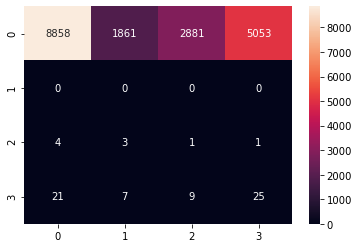

In [42]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

COMPLEX FULLY CONNECTED, PASSING

In [43]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_pass_x.shape[1],), 
                activation='relu', 
                kernel_initializer='he_normal'))
model.add(Dense(20,  
                activation='relu', 
                kernel_initializer='he_normal'))
model.add(Dense(20, 
                activation='relu', 
                kernel_initializer='he_normal'))
model.add(Dropout(0.2))
    
model.add(Dense(4, 
                activation='softmax'))



model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
841/841 [==============================] - 2s 2ms/step - loss: 1.2190 - accuracy: 0.4704 - val_loss: 1.2122 - val_accuracy: 0.4690
Epoch 2/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2097 - accuracy: 0.4713 - val_loss: 1.2094 - val_accuracy: 0.4690
Epoch 3/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2081 - accuracy: 0.4714 - val_loss: 1.2065 - val_accuracy: 0.4690
Epoch 4/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2068 - accuracy: 0.4712 - val_loss: 1.2062 - val_accuracy: 0.4691
Epoch 5/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2053 - accuracy: 0.4715 - val_loss: 1.2047 - val_accuracy: 0.4690
Epoch 6/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2050 - accuracy: 0.4712 - val_loss: 1.2061 - val_accuracy: 0.4690
Epoch 7/1000
841/841 [==============================] - 1s 1ms/step - loss: 1.2041 - accuracy: 0.4713 - val_loss: 1.2025 - val_accuracy:

In [44]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 813us/step - loss: 1.1968 - accuracy: 0.4746


[1.1967803239822388, 0.4745780825614929]

<AxesSubplot:>

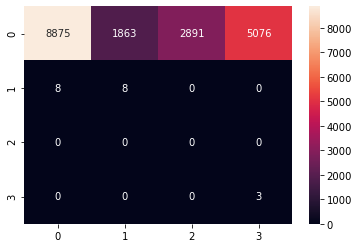

In [45]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

BASIC MODEL, RESIDUAL CONNECTION

In [46]:
# Model
inp = Input(shape=(X_train.shape[1],))

x = inp
x = Dense(10, activation='relu', 
              kernel_initializer='he_normal')(x)
x = Dense(5, activation='relu', 
             kernel_initializer='he_normal')(x)

res = Dense(5, activation='relu', 
               kernel_initializer='he_normal')(inp)

x = add([x,res])

out = Dense(4, activation='softmax')(x)

In [47]:
model = Model(inputs = inp, outputs=out)

In [48]:
es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
841/841 [==============================] - 2s 1ms/step - loss: 1.2248 - accuracy: 0.4704 - val_loss: 1.2205 - val_accuracy: 0.4690
Epoch 2/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2197 - accuracy: 0.4713 - val_loss: 1.2346 - val_accuracy: 0.4690
Epoch 3/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2193 - accuracy: 0.4707 - val_loss: 1.2246 - val_accuracy: 0.4682
Epoch 4/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2181 - accuracy: 0.4713 - val_loss: 1.2191 - val_accuracy: 0.4690
Epoch 5/10000
841/841 [==============================] - ETA: 0s - loss: 1.2182 - accuracy: 0.47 - 1s 2ms/step - loss: 1.2179 - accuracy: 0.4711 - val_loss: 1.2174 - val_accuracy: 0.4690
Epoch 6/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2170 - accuracy: 0.4714 - val_loss: 1.2237 - val_accuracy: 0.4690
Epoch 7/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2174 - ac

In [49]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 1s 818us/step - loss: 1.2117 - accuracy: 0.4744


[1.2116719484329224, 0.47441786527633667]

<AxesSubplot:>

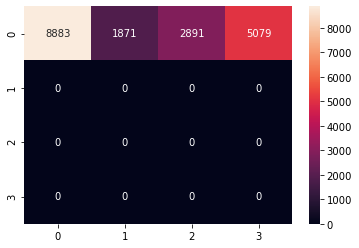

In [50]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

COMPLEX MODEL, RESIDUAL CONNECTION

In [51]:
inp = Input(shape=(X_train.shape[1],))

x = inp
# first pair
x = Dense(8, activation='sigmoid')(x)
x = Dense(4, activation='sigmoid')(x)
res1 = Dense(4, activation='sigmoid')(inp) # connection to the first pair
x = add([x,res1]) # add first residual with first pair

res2 = Dense(5, activation='sigmoid')(x) # connection to second paiR

# second pair
x = Dense(10, activation='sigmoid')(x)
x = Dense(5, activation='sigmoid')(x)
x = add([x,res2]) # add second residual with second pair

res3 = Dense(5, activation='sigmoid')(inp) # connection across the whole network, beginning to second residual connection
x = add([x, res3]) # add overaching residual with the output of the second pair/residual addition (x)

out = Dense(4, activation='softmax')(x)

In [52]:
model = Model(inputs = inp, outputs=out)

es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
841/841 [==============================] - 2s 2ms/step - loss: 1.2244 - accuracy: 0.4691 - val_loss: 1.2185 - val_accuracy: 0.4689
Epoch 2/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2131 - accuracy: 0.4702 - val_loss: 1.2158 - val_accuracy: 0.4688
Epoch 3/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2112 - accuracy: 0.4711 - val_loss: 1.2147 - val_accuracy: 0.4690
Epoch 4/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2110 - accuracy: 0.4709 - val_loss: 1.2126 - val_accuracy: 0.4690
Epoch 5/10000
841/841 [==============================] - 1s 1ms/step - loss: 1.2102 - accuracy: 0.4710 - val_loss: 1.2104 - val_accuracy: 0.4690
Epoch 6/10000
841/841 [==============================] - 1s 2ms/step - loss: 1.2111 - accuracy: 0.4712 - val_loss: 1.2105 - val_accuracy: 0.4679
Epoch 7/10000
841/841 [==============================] - 1s 2ms/step - loss: 1.2118 - accuracy: 0.4711 - val_loss: 1.2135 - val_ac

In [53]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 1s 839us/step - loss: 1.2065 - accuracy: 0.4744


[1.2065118551254272, 0.47441786527633667]

<AxesSubplot:>

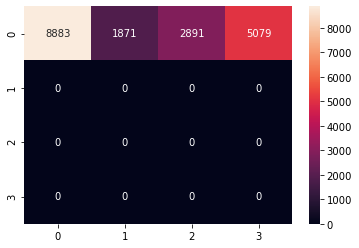

In [54]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

RUSH DATA

In [55]:
# feature, or input, dataframe
NFL_rush_x  = NFL_rush.drop(['yards_gained', 'play_type'], axis=1)
NFL_rush_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,qb_kneel,qb_spike
176362,352.0,50.0,7,41.0,10.0,3.92,20.8,2.0,0,0,0
106976,2852.0,70.0,10,0.0,7.0,3.80,43.7,1.0,0,0,0
268634,2479.0,85.0,5,17.0,0.0,4.43,47.9,2.0,1,0,0
6567,505.0,73.0,10,20.0,19.0,4.44,61.6,1.0,0,0,0
183987,2802.0,80.0,10,10.0,10.0,3.92,20.8,1.0,1,0,0


In [56]:
NFL_rush_x = NFL_rush_x.values
NFL_rush_x

array([[3.520e+02, 5.000e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.852e+03, 7.000e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.479e+03, 8.500e+01, 5.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.103e+03, 4.400e+01, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.938e+03, 5.100e+01, 9.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.620e+02, 4.000e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [57]:
# label, or output, dataframe
NFL_rush_y = NFL_rush['yards_gained'].values
NFL_rush_y

array([0., 1., 0., ..., 1., 1., 0.])

In [58]:
# covert the yards gained into categorical variables
NFL_rush_y = tf.keras.utils.to_categorical(NFL_rush_y, num_classes=4)
print(NFL_rush_y[0])

[1. 0. 0. 0.]


In [59]:
#split the data
valid_split = 0.2
test_split = 0.1

In [60]:
# create the splits in the dataframe
v_split = int(NFL_rush.shape[0]*(1-valid_split-test_split))
t_split = int(NFL_rush.shape[0]*(1-test_split))

# assign training, validation, and test data
X_train, Y_train  = NFL_rush_x[:v_split], NFL_rush_y[:v_split]
X_valid, Y_valid  = NFL_rush_x[v_split:t_split], NFL_rush_y[v_split:t_split]
X_test , Y_test   = NFL_rush_x[t_split:], NFL_rush_y[t_split:]

In [61]:
#standardize the data
scaler = preprocessing.StandardScaler().fit(X_train[:,0:7]) # mean and variance calculated on specified columns of X_train
X_train[:,0:7] = scaler.transform(X_train[:,0:7])
X_valid[:,0:7] = scaler.transform(X_valid[:,0:7])
X_test[:,0:7]  = scaler.transform(X_test[:,0:7])  

BASIC MODEL, RUSHING

In [62]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_rush_x.shape[1],), 
                activation='relu', 
                kernel_initializer='he_normal'))
model.add(Dense(4, 
                activation='softmax'))

In [63]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])

In [64]:
es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

In [65]:
model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2489 - accuracy: 0.4342 - val_loss: 1.2401 - val_accuracy: 0.4361
Epoch 2/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2425 - accuracy: 0.4351 - val_loss: 1.2450 - val_accuracy: 0.4361
Epoch 3/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2422 - accuracy: 0.4367 - val_loss: 1.2406 - val_accuracy: 0.4361
Epoch 4/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2434 - accuracy: 0.4373 - val_loss: 1.2444 - val_accuracy: 0.4361
Epoch 5/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2439 - accuracy: 0.4373 - val_loss: 1.2454 - val_accuracy: 0.4361
Epoch 6/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2441 - accuracy: 0.4374 - val_loss: 1.2470 - val_accuracy: 0.4361
Epoch 7/1000
603/603 [==============================] - 1s 2ms/step - loss: 1.2450 - accuracy: 0.4358 - val_loss: 1.2459 - val_accuracy:

In [66]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 788us/step - loss: 1.2463 - accuracy: 0.4319


[1.2463256120681763, 0.43191298842430115]

<AxesSubplot:>

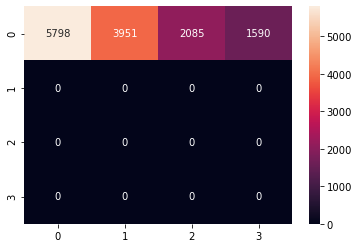

In [67]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

COMPLEX FULLY CONNECTED, RUSHING

In [68]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                activation='tanh'))
model.add(Dense(20, 
                activation='tanh'))
model.add(Dense(20,  
                activation='tanh'))
model.add(Dense(4, 
                activation='softmax'))


model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2903 - accuracy: 0.4066 - val_loss: 1.2815 - val_accuracy: 0.4017
Epoch 2/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2840 - accuracy: 0.4103 - val_loss: 1.2570 - val_accuracy: 0.4265
Epoch 3/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2858 - accuracy: 0.4096 - val_loss: 1.3300 - val_accuracy: 0.3061
Epoch 4/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2828 - accuracy: 0.4100 - val_loss: 1.2565 - val_accuracy: 0.4361
Epoch 5/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2880 - accuracy: 0.4094 - val_loss: 1.2677 - val_accuracy: 0.3790
Epoch 6/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2884 - accuracy: 0.4075 - val_loss: 1.2925 - val_accuracy: 0.3823
Epoch 7/1000
603/603 [==============================] - 1s 1ms/step - loss: 1.2859 - accuracy: 0.4098 - val_loss: 1.3075 - val_accuracy:

In [69]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 814us/step - loss: 1.2618 - accuracy: 0.4319


[1.2617608308792114, 0.43191298842430115]

<AxesSubplot:>

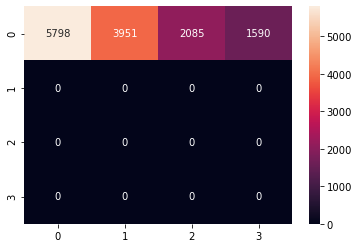

In [70]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

BASIC MODEL, RESIDUAL CONNECTIONS

In [71]:
# Model
inp = Input(shape=(X_train.shape[1],))

x = inp
x = Dense(10, activation='relu', 
              kernel_initializer='he_normal')(x)
x = Dense(5, activation='relu', 
             kernel_initializer='he_normal')(x)

res = Dense(5, activation='relu', 
               kernel_initializer='he_normal')(inp)

x = add([x,res])

out = Dense(4, activation='softmax')(x)

In [72]:
model = Model(inputs = inp, outputs=out)

In [73]:
es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          epochs=10000, 
          batch_size=156,
          callbacks=[es])

Epoch 1/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2493 - accuracy: 0.4357 - val_loss: 1.2540 - val_accuracy: 0.4361
Epoch 2/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2450 - accuracy: 0.4367 - val_loss: 1.2511 - val_accuracy: 0.4361
Epoch 3/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2424 - accuracy: 0.4372 - val_loss: 1.2450 - val_accuracy: 0.4361
Epoch 4/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2423 - accuracy: 0.4374 - val_loss: 1.2473 - val_accuracy: 0.4361
Epoch 5/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2421 - accuracy: 0.4369 - val_loss: 1.2429 - val_accuracy: 0.4361
Epoch 6/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2423 - accuracy: 0.4373 - val_loss: 1.2446 - val_accuracy: 0.4361
Epoch 7/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2436 - accuracy: 0.4368 - val_loss: 1.2510 - val_ac

In [74]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 772us/step - loss: 1.2489 - accuracy: 0.4319


[1.2489216327667236, 0.43191298842430115]

<AxesSubplot:>

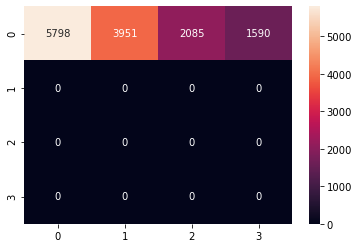

In [75]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

COMPLEX MODEL, RESIDUAL CONNECTIONS

In [76]:
inp = Input(shape=(X_train.shape[1],))

x = inp
# first pair
x = Dense(8, activation='relu', 
             kernel_initializer='he_normal')(x)
x = Dense(4, activation='relu', 
             kernel_initializer='he_normal')(x)
res1 = Dense(4, activation='relu', 
                kernel_initializer='he_normal')(inp) # connection to the first pair
x = add([x,res1]) # add first residual with first pair

res2 = Dense(5, activation='relu', 
                kernel_initializer='he_normal')(x) # connection to second paiR

# second pair
x = Dense(10, activation='relu', 
              kernel_initializer='he_normal')(x)
x = Dense(5, activation='relu', 
             kernel_initializer='he_normal')(x)
x = add([x,res2]) # add second residual with second pair

res3 = Dense(5, activation='relu', 
                kernel_initializer='he_normal')(inp) # connection across the whole network, beginning to second residual connection
x = add([x, res3]) # add overaching residual with the output of the second pair/residual addition (x)

out = Dense(4, activation='softmax')(x)


model = Model(inputs = inp, outputs=out)

es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.1),
              metrics=['accuracy'])
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
603/603 [==============================] - 2s 2ms/step - loss: 1.2499 - accuracy: 0.4356 - val_loss: 1.2509 - val_accuracy: 0.4361
Epoch 2/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2475 - accuracy: 0.4355 - val_loss: 1.2488 - val_accuracy: 0.4361
Epoch 3/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2471 - accuracy: 0.4373 - val_loss: 1.2485 - val_accuracy: 0.4361
Epoch 4/10000
603/603 [==============================] - 1s 1ms/step - loss: 1.2449 - accuracy: 0.4374 - val_loss: 1.2462 - val_accuracy: 0.4361
Epoch 5/10000
603/603 [==============================] - 1s 2ms/step - loss: 1.2456 - accuracy: 0.4367 - val_loss: 1.2451 - val_accuracy: 0.4361
Epoch 6/10000
603/603 [==============================] - 1s 2ms/step - loss: 1.2443 - accuracy: 0.4366 - val_loss: 1.2466 - val_accuracy: 0.4361
Epoch 7/10000
603/603 [==============================] - 1s 2ms/step - loss: 1.2446 - accuracy: 0.4374 - val_loss: 1.2536 - val_ac

In [77]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 795us/step - loss: 1.2469 - accuracy: 0.4319


[1.246877670288086, 0.43191298842430115]

<AxesSubplot:>

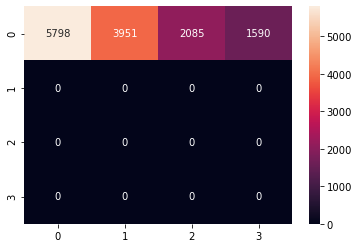

In [78]:
preds = model.predict(X_test)
preds_label = np.argmax(preds, axis=1)

conf = confusion_matrix(preds_label, np.argmax(Y_test, axis=1))
sns.heatmap(conf, annot=True, fmt='d')

GUESSING THE MAJORITY (PASSING)

In [79]:
sum = (NFL_pass['yards_gained'] == 0).value_counts()
target_majority = sum[1]/len(NFL_pass)
print("Majority Guess:", target_majority)

Majority Guess: 0.47128161852674755


GUESSING THE MAJORITY (RUSHING)

In [80]:
sum = (NFL_rush['yards_gained'] == 0).value_counts()
target_majority = sum[1]/len(NFL_rush)
print("Majority Guess:", target_majority)

Majority Guess: 0.4365785886156574


MULTIPLE LOGISTIC REGRESSION BASELINE (PASSING)

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [82]:
pass_attrs = NFL_pass_x
pass_labels = NFL_pass['yards_gained']

In [83]:
pass_features_train, pass_features_test, pass_labels_train, pass_labels_test = train_test_split(pass_attrs, pass_labels, test_size=0.33, random_state=22)

In [84]:
lm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lm.fit(pass_features_train, pass_labels_train)
pred_test = lm.predict(pass_features_test)

In [85]:
lm_accuracy = np.mean((pass_labels_test == pred_test))
print("Accuracy:", lm_accuracy)

Accuracy: 0.46765500833508666


MULTIPLE LOGISTIC REGRESSION BASELINE (RUSHING)

In [86]:
rush_attrs = NFL_rush_x
rush_labels = NFL_rush['yards_gained']

In [87]:
rush_features_train, rush_features_test, rush_labels_train, rush_labels_test = train_test_split(rush_attrs, rush_labels, test_size=0.33, random_state=22)

In [88]:
lm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lm.fit(rush_features_train, rush_labels_train)
pred_test = lm.predict(rush_features_test)

In [89]:
lm_accuracy = np.mean((rush_labels_test == pred_test))
print("Accuracy:", lm_accuracy)

Accuracy: 0.4329894580013093
